In [41]:
import numpy as np
from scipy.stats import halfnorm
from scipy.stats import expon
from scipy import stats
import matplotlib.pyplot as plt

In [74]:
class Simulator:
    def __init__(self, nu: int, gamma: int, sigma_min: float, sigma_max: float,
                 x: callable, func: callable, ineff_dist: str = 'half-normal'):
        """
        Simulation class for stochastic frontier meta-analysis.
        
        nu
            The scale of the inefficiency term
        gamma
            The variance of the random effect term
        sigma_min, sigma_max
            The study-specific errors, max and minimum. They will be drawn from a uniform distribution.
        x
            A callable function to generate a realization from a random variable x (is the covariate used
            to construct the frontier). Needs to have an argument size.
        func
            A function of x that defines the frontier
        ineff_dist
            Inefficiency distribution
        """
        self.nu = nu
        self.gamma = gamma
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.x = x
        self.func = func
        
        if ineff_dist == 'half-normal':
            self.rvs = halfnorm.rvs
        elif ineff_dist == 'exponential':
            self.rvs = expon.rvs
        else:
            raise RuntimeError("Inefficiency distribution must be half-normal or exponential")
    
    def simulate(self, n: int = 1, **kwargs):
        sigma = stats.uniform.rvs(loc=self.sigma_min, scale=self.sigma_max, size=n)
        epsilon = stats.norm.rvs(loc=0, scale=sigma, size=n)
        
        us = stats.norm.rvs(loc=0, scale=self.gamma, size=n)
        vs = self.rvs(scale=self.nu, size=n)
        
        xs = self.x(size=n, **kwargs)
        front = self.func(xs)
        observed = front + us - vs + epsilon
        return us, vs, epsilon, xs, front, observed

In [92]:
s = Simulator(nu=1, gamma=1.5, sigma_min=0, sigma_max=1, 
              x=lambda size: stats.norm.rvs(size=size, loc=-.5), func=np.exp)
us, vs, epsilon, xs, front, observed = s.simulate(n = 100)

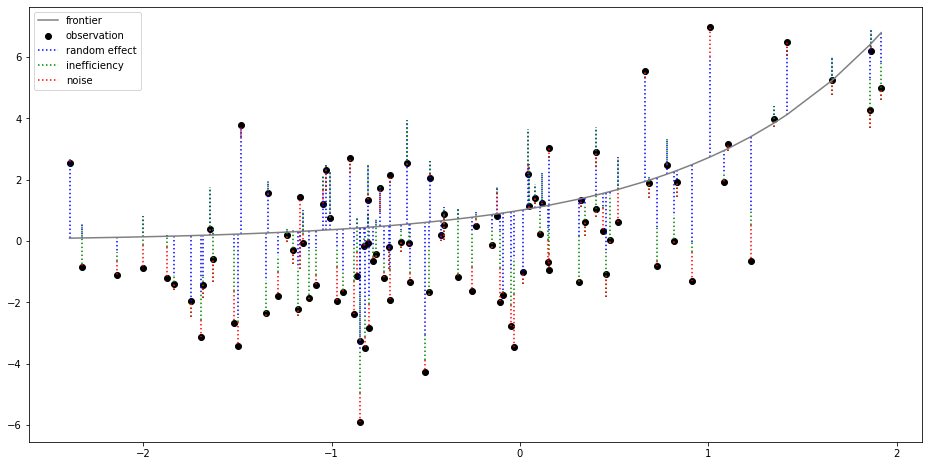

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.scatter(xs, observed, label="observation", color='black')
ax.plot(sorted(xs), sorted(front), linestyle='-', color='grey', label="frontier")
ax.vlines(xs, ymin=front, ymax=front+us, color='blue', linestyle=':', label="random effect")
ax.vlines(xs, ymin=front+us-vs, ymax=front+us, color='green', linestyle=':', label="inefficiency")
ax.vlines(xs, ymin=front+us-vs, ymax=front+us-vs+epsilon, color='red', linestyle=':', label="noise")
ax.legend()